# Aplicación del modelo de aprendizaje automático no supervisado K-Means (1-D) para efectos de identificar los clusters y el umbral máximo a partir del cual un operador de telecomunicaciones se considera pequeño para efectos de determinar su elegibilidad en el Comité de Pequeños Operadores.

### Datos

El umbral máximo para determinar si un proveedor de servicios de telecomunicaciones, con fines comerciales, es elegible para participar en el Comité, será calculado a partir de los datos de ingreso nominal acumulados anualmente (al cuarto trimestre del año anterior), los cuales han sido reportados por los operadores y publicados en el Banco de Información de Telecomunicaciones del Instituto Federal de Telecomunicaciones.

Como primer paso, serán acumulados los ingresos anuales publicados en el Banco de Información de Telecomunicaciones, con información al cierre del cuarto trimestre del año inmediato anterior y se realizan algunos ajustes tendientes a consolidar los datos por grupo de interés económico, a fin de comenzar el análisis correspondiente.


### Metodología

El referido umbral se calcula a partir del método de agrupamiento conocido como k-medias o k-means (como se le denomina en el idioma inglés). Se trata de un algoritmo de aprendizaje automático no supervisado que busca identificar los grupos de observaciones (i.e. los ingresos nominales acumulados anualmente) que son similares. Para ello, se parte del concepto básico de “distancia” para determinar similitudes entre los operadores de telecomunicaciones. Por ejemplo, si tomamos los ingresos nominales acumulados anuales de dos empresas, la distancia entre sus respectivos datos es una medida del grado de cercanía o similitud que existe entre las mismas.

Como se ilustra en el siguiente diagrama, se define aleatoriamente un prototipo para cada grupo y se mide la distancia que tienen los ingresos nominales acumulados anualmente de cada elemento respecto al prototipo o centroide (v.gr. punto medio de los objetos). Posteriormente, ese centroide se vuelve a definir para cada grupo y este proceso se repite hasta que los objetos no cambien de grupo y que los centroides no sufran variaciones; lo que confirma que existe evidencia de que los grupos están correctamente definidos.

Para la determinación del número óptimo de clusters o grupos (k), se utiliza el criterio denominado Elbow, que consiste en seleccionar el k donde la reducción de la suma de la distancia cuadrática de los elementos de cada grupo a su centroide (inercia) ya no es significativa. Lo que implica que un cluster adicional ya no aumenta significativamente la similitud entre los elementos de cada grupo, reduciendo la eficiencia en la agrupación sin una ganancia significativa en la convergencia o similitud de cada elemento en cada grupo . En este sentido, el principio de selección óptima de k es el de tener un valor reducido de inercia y el número menor de centroides o agrupaciones.

<img title="a title" alt="Alt text" src="kmeans.png">


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.cluster.vq import vq, kmeans, whiten
import dataframe_image as dfi
import math
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
# Es importante mencionar que esta base de datos proviene de la última actualización en el Banco de Información de Telecomunicaciones
# del IFT, consultado el 19 de agosto de 2022. 
# Por este motivo se incluye en este repositorio esa versión de la base de datos a efectos de que si desea replicar el 
# resultado, lo haga con este conjunto de datos, toda vez que la información en el BIT podría variar sin previo aviso.

ingresos = pd.read_csv('TD_INGRESOS_TELECOM_ITE_VA_octubre.csv', encoding ='Latin1')
ingresos

,FOLIO,ANIO,TRIM,FECHA,CONCESIONARIO,K_EMPRESA,EMPRESA,K_GRUPO,GRUPO,I_FIJO_MOVIL,INGRESOS_TOTAL_E,I_ANUAL_TRIM
0,100025,2021,1,15-mar-21,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
1,100025,2021,2,15-jun-21,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
2,100025,2021,3,15-sep-21,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
3,100025,2021,4,15DEC2021,ABILIO VILLARREAL MORGA,C0004,ABILIO VILLARREAL MORGA,C004,ABILIO VILLARREAL MORGA,Fijo,0,Trimestral
4,100028,2021,1,15-mar-21,ADOLFO MERINO MEDINA,C0089,CABLEMAS,G004,GRUPO TELEVISA,Fijo,389669,Trimestral
...,...,...,...,...,...,...,...,...,...,...,...,...
2646,999997,2014,2,15-jun-14,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2647,999997,2014,3,15-sep-14,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2648,999997,2014,4,15DEC2014,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2649,999997,2015,1,15-mar-15,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral


In [4]:
ingresos['GRUPO'].unique()

array(['ABILIO VILLARREAL MORGA', 'GRUPO TELEVISA',
       'AGUSTIN PEREZ VIEYRA', 'ALEJANDRO ALFONSO MELGAREJO ALTAMIRANO',
       'ALEJANDRO MELGAREJO CORTES', 'ARELY ISABEL GONGORA PECH',
       'ADA CRISTINA MAGAÑA CASTRO', 'DANIEL GARCIA GODINEZ',
       'FRANCISCO GUERRA GARCIA', 'GABRIEL BUTRON CHIAPA',
       'GENY MARGARITA MOGUEL REJON', 'GUILLERMO MEDELLIN MILAN',
       'GUILLERMO ZARATE GARCIA', 'JAIME SANCHEZ SANCHEZ',
       'JESUS MIGUEL FERNANDEZ GUERRERO', 'JOSE JULIAN SACRAMENTO GARZA',
       'MANUEL LOPEZ AVILA', 'MARCO ANTONIO ROSALES HERRERA',
       'RAFAEL SANCHEZ NAZARIEGA', 'ROBERTO LOPEZ BRAVO',
       'SARA QUIROZ CHAPA', 'IUSACELL-UNEFÓN', 'LOGITEL', 'TV-K',
       'TELEFÓNICA', 'COSMORED', 'TELECAB', 'ULTRAVISION', 'STARGROUP',
       'ALESTRA', 'AXTEL', 'MEGACABLE-MCM', 'TELECABLE DE RIOVERDE',
       'GRUPO TELECABLE', 'GLOBALSAT', 'TELECOM NACIONAL',
       'GRUPO SALINAS', 'AXESAT', 'AIRECABLE', 'CABLECOM', 'USA TELECOM',
       'CODITEL', 'COMCAB', '

In [5]:
len(ingresos['GRUPO'].unique())

198

In [6]:
ingresos.columns

Index(['FOLIO', 'ANIO', 'TRIM', 'FECHA', 'CONCESIONARIO', 'K_EMPRESA',
       'EMPRESA', 'K_GRUPO', 'GRUPO', 'I_FIJO_MOVIL', 'INGRESOS_TOTAL_E',
       'I_ANUAL_TRIM'],
      dtype='object')

In [7]:
# seleccionamos columnas relevantes
variables_relevantes = ['ANIO','TRIM', 'CONCESIONARIO', 'EMPRESA', 'GRUPO', 'INGRESOS_TOTAL_E']

ingresos2 = ingresos[variables_relevantes]
ingresos2

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
1,2021,2,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
2,2021,3,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
3,2021,4,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
4,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
...,...,...,...,...,...,...
2646,2014,2,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2647,2014,3,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2648,2014,4,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2649,2015,1,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN


In [8]:
# seleccionar sólo los registro de 2021
ingresos = ingresos2[ingresos2['ANIO']==2021]
ingresos

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
1,2021,2,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
2,2021,3,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
3,2021,4,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
4,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
...,...,...,...,...,...,...
2636,2021,1,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2637,2021,2,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2638,2021,3,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2639,2021,4,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,123094


# Corrección de grupos de interés en el conjunto de datos

Con base en la información proporcionada por la Unidad de Competencia Económica respecto a los Grupos de Interés que tienen identificados, se realizaron los siguientes cambios al marco de datos de ingresos que estamos utilizando para el cálculo del umbral de pequeño operador; publicado en el BIT al 19 de agosto de 2022:

- Se incluye en el grupo de interés económico HISPASAT a la empresa AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.
- Se incluye en el grupo de interés económico GRUPO TELEVISA a la empresa GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD, S.A.P.I. DE C.V. (GTAC).
- Se incluye en el grupo de interés económico TRANSTELCO a la empresa MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.
- Se incluyen en el grupo de interés económico MVS las empresas: MVSTV y DSH.


In [9]:
# Primero HISPASAT
print(ingresos[ingresos['EMPRESA']=='AXESS'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['AXESAT'],'HISPASAT')
ingresos[ingresos['EMPRESA']=='AXESS']

     ANIO  TRIM                             CONCESIONARIO EMPRESA   GRUPO  \
385  2021     2  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   
386  2021     3  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   
387  2021     4  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   

     INGRESOS_TOTAL_E  
385          60667313  
386          68625291  
387          88628131  


<ipython-input-9-7dc6878566fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['AXESAT'],'HISPASAT')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
385,2021,2,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,60667313
386,2021,3,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,68625291
387,2021,4,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,88628131


In [10]:
# Segundo Grupo Televisa
print(ingresos[ingresos['CONCESIONARIO']=='GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD, S.A.P.I. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['GTAC REDES DE FIBRA OPTICA'],'GRUPO TELEVISA')
ingresos[ingresos['EMPRESA']=='GTAC REDES DE FIBRA OPTICA']

     ANIO  TRIM                                      CONCESIONARIO  \
581  2021     1  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
582  2021     2  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
583  2021     3  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
584  2021     4  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   

                        EMPRESA                       GRUPO  INGRESOS_TOTAL_E  
581  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         228948471  
582  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         196098888  
583  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         355289838  
584  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA         282197600  


<ipython-input-10-98df99182ec1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['GTAC REDES DE FIBRA OPTICA'],'GRUPO TELEVISA')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
581,2021,1,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,228948471
582,2021,2,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,196098888
583,2021,3,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,355289838
584,2021,4,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,282197600


In [11]:
# Tercero Transtelco
print(ingresos[ingresos['CONCESIONARIO']=='MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MAXCOM'],'TRANSTELCO')
ingresos[ingresos['EMPRESA']=='MAXCOM']

      ANIO  TRIM                              CONCESIONARIO EMPRESA   GRUPO  \
1896  2021     1  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1897  2021     2  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1898  2021     3  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1899  2021     4  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   

      INGRESOS_TOTAL_E  
1896         154326158  
1897         157745550  
1898         154123979  
1899         157402483  


<ipython-input-11-19fa40c9fb05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MAXCOM'],'TRANSTELCO')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1896,2021,1,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,154326158
1897,2021,2,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,157745550
1898,2021,3,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,154123979
1899,2021,4,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,157402483


In [12]:
ingresos[ingresos['EMPRESA']=='DISH']

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1103,2021,1,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1373486398
1104,2021,2,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1298658657
1105,2021,3,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1264047268
1106,2021,4,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1211104115


In [13]:
# Quinto DISH-MVS
print(ingresos[ingresos['CONCESIONARIO']=='COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S. DE R.L. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['DISH-MVS'],'MVS')
ingresos[ingresos['EMPRESA']=='DISH']

      ANIO  TRIM                                      CONCESIONARIO EMPRESA  \
1103  2021     1  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1104  2021     2  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1105  2021     3  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1106  2021     4  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   

         GRUPO  INGRESOS_TOTAL_E  
1103  DISH-MVS        1373486398  
1104  DISH-MVS        1298658657  
1105  DISH-MVS        1264047268  
1106  DISH-MVS        1211104115  


<ipython-input-13-3309da2ae005>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['DISH-MVS'],'MVS')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1103,2021,1,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1373486398
1104,2021,2,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1298658657
1105,2021,3,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1264047268
1106,2021,4,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1211104115


In [14]:
# Sexto DISH-MVS
print(ingresos[ingresos['EMPRESA']=='MVSTV'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MVSTV'],'MVS')
ingresos[ingresos['EMPRESA']=='MVSTV']

      ANIO  TRIM          CONCESIONARIO EMPRESA GRUPO  INGRESOS_TOTAL_E
1764  2021     1  COMBAND, S.A. DE C.V.   MVSTV   MVS           1854471
1765  2021     2  COMBAND, S.A. DE C.V.   MVSTV   MVS           1355173
1766  2021     3  COMBAND, S.A. DE C.V.   MVSTV   MVS           2842491
1767  2021     4  COMBAND, S.A. DE C.V.   MVSTV   MVS           5357193


<ipython-input-14-b827a2e0f14c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MVSTV'],'MVS')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1764,2021,1,"COMBAND, S.A. DE C.V.",MVSTV,MVS,1854471
1765,2021,2,"COMBAND, S.A. DE C.V.",MVSTV,MVS,1355173
1766,2021,3,"COMBAND, S.A. DE C.V.",MVSTV,MVS,2842491
1767,2021,4,"COMBAND, S.A. DE C.V.",MVSTV,MVS,5357193


In [15]:
# Existen huecos en los datos públicos en proveedores importantes como Axtel (4T2021), Cablevisión, Virgin Mobile (4T2021), QBO CEL (2T Y 4T2021), por mencionar algunos.
ingresos[ingresos['INGRESOS_TOTAL_E'].isna()==True]
# no obstante, partimos de que es la información disponible para este ejercicio.

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
570,2021,2,"CABLEMAS TELECOMUNICACIONES, S.A. DE C.V.",IZZI,GRUPO TELEVISA,NaN
790,2021,2,"CABLEVISION RED, S.A. DE C.V.",CABLEVISION RED,GRUPO TELEVISA,NaN
866,2021,2,"TV CABLE DE ORIENTE, S.A. DE C.V.",IZZI,GRUPO TELEVISA,NaN
968,2021,2,"TELEVISION INTERNACIONAL, S.A. DE C.V.",TELEVISION INTERNACIONAL,GRUPO TELEVISA,NaN
1494,2021,2,"CABLEVISION, S.A. DE C.V.",CABLEVISION,GRUPO TELEVISA,NaN
1862,2021,3,"CTL MEXICO LANDING, S. DE R.L.",CENTURYLINK,CENTURYLINK,NaN
2025,2021,4,"VIRGIN MOBILE MEXICO, S. DE R.L. DE C.V.",VIRGIN MOBILE,VIRGIN MOBILE,NaN
2106,2021,2,"KUBO CEL, S.A.P.I. DE C.V.",QBO CEL,QBO CEL,NaN
2108,2021,4,"KUBO CEL, S.A.P.I. DE C.V.",QBO CEL,QBO CEL,NaN
2194,2021,1,"MVS NET, S.A. DE C.V.",MVS,MVS,NaN


In [16]:
ingresos.dtypes

ANIO                  int64
TRIM                  int64
CONCESIONARIO        object
EMPRESA              object
GRUPO                object
INGRESOS_TOTAL_E    float64
dtype: object

In [17]:
# no consideremos los missing values

ingresos = ingresos[ingresos['INGRESOS_TOTAL_E'].isna()!=True]
ingresos

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
1,2021,2,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
2,2021,3,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
3,2021,4,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,ABILIO VILLARREAL MORGA,0
4,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
...,...,...,...,...,...,...
2636,2021,1,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2637,2021,2,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2638,2021,3,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,0
2639,2021,4,"CITRO TELECOM, S.A. DE C.V.",CITRO TELECOM,CITRO TELECOM,123094


In [18]:
lista_columnas = ['GRUPO', 'INGRESOS_TOTAL_E']
ingresos2 = ingresos[lista_columnas]
ingresos2

,GRUPO,INGRESOS_TOTAL_E
0,ABILIO VILLARREAL MORGA,0
1,ABILIO VILLARREAL MORGA,0
2,ABILIO VILLARREAL MORGA,0
3,ABILIO VILLARREAL MORGA,0
4,GRUPO TELEVISA,389669
...,...,...
2636,CITRO TELECOM,0
2637,CITRO TELECOM,0
2638,CITRO TELECOM,0
2639,CITRO TELECOM,123094


In [19]:
ingresos2['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos2['INGRESOS_TOTAL_E'])

<ipython-input-19-0e8230c4d54c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos2['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos2['INGRESOS_TOTAL_E'])


In [20]:
# ya no tenemos missings

ingresos2

,GRUPO,INGRESOS_TOTAL_E
0,ABILIO VILLARREAL MORGA,0
1,ABILIO VILLARREAL MORGA,0
2,ABILIO VILLARREAL MORGA,0
3,ABILIO VILLARREAL MORGA,0
4,GRUPO TELEVISA,389669
...,...,...
2636,CITRO TELECOM,0
2637,CITRO TELECOM,0
2638,CITRO TELECOM,0
2639,CITRO TELECOM,123094


In [21]:
# Agrupados
ingresos_agrupados = ingresos2.groupby(['GRUPO']).sum()
ingresos_agrupados

,INGRESOS_TOTAL_E
GRUPO,
ABILIO VILLARREAL MORGA,0
ADA CRISTINA MAGAÑA CASTRO,0
ADDINTELI,5534961
AGUSTIN PEREZ VIEYRA,2726562
AIRECABLE,13327321
...,...
VERIZON SERVICIOS EMPRESARIALES MEXICO,195055919
VIRGIN MOBILE,146563495
WEEX,33446465


In [22]:
ingresos_agrupados = ingresos_agrupados.reset_index().sort_values(by=['INGRESOS_TOTAL_E'], ascending=False)
ingresos_agrupados

,GRUPO,INGRESOS_TOTAL_E
9,AMÉRICA MÓVIL,338320139531
56,GRUPO TELEVISA,59302114566
12,AT&T,55793781168
84,MEGACABLE-MCM,25905272620
139,TELEFÓNICA,24871583943
...,...,...
108,SERGIO PEDROZA AGUILERA,0
1,ADA CRISTINA MAGAÑA CASTRO,0
73,JOAQUIN LEON ASPANO,0
26,CABLEXTREMO,0


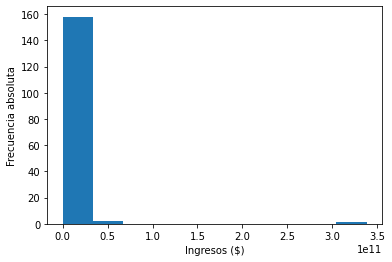

NormaltestResult(statistic=335.1417446263944, pvalue=1.67839751044495e-73)


In [23]:
plt.hist(ingresos_agrupados['INGRESOS_TOTAL_E'])
plt.xlabel('Ingresos ($)')
plt.ylabel('Frecuencia absoluta')
plt.show()
print(sts.normaltest(ingresos_agrupados['INGRESOS_TOTAL_E'])) # no pasa la prueba de normalidad (sesgo)

In [24]:
# cuántos ceros tenemos en las cifras
m = ingresos_agrupados[ingresos_agrupados['INGRESOS_TOTAL_E']!=0]

ingresos_agrupados_transformables = m

ingresos_agrupados_transformables

,GRUPO,INGRESOS_TOTAL_E
9,AMÉRICA MÓVIL,338320139531
56,GRUPO TELEVISA,59302114566
12,AT&T,55793781168
84,MEGACABLE-MCM,25905272620
139,TELEFÓNICA,24871583943
...,...,...
40,EDUARDO PEDRERO PEREZ,68200
13,AXIA CABLECENTRO,43500
31,COMNET,43293
103,REX MOVIL,11422


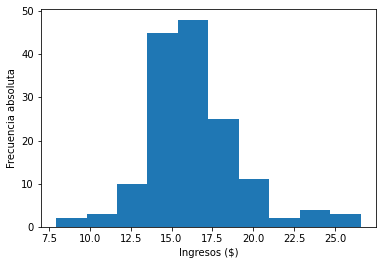

NormaltestResult(statistic=20.812485323225516, pvalue=3.024309507239512e-05)


In [25]:
# Aplicar logarítmos para reducir el efecto de la magnitud de los datos.
ln_ingresos = np.log(ingresos_agrupados_transformables['INGRESOS_TOTAL_E']) 

plt.hist(ln_ingresos)
plt.xlabel('Ingresos ($)')
plt.ylabel('Frecuencia absoluta')
plt.show()
print(sts.normaltest(ln_ingresos))

In [26]:
# Análisis de varianza
var_numpy = np.var(ln_ingresos, ddof = 0)
print(f"La varianza del ln de los ingresos totales en 2021 es de {var_numpy}")
print(f'Lo que implica $ {np.exp(var_numpy)}')

sd_numpy = np.std(ln_ingresos,ddof = 0)
print(f"La desviación estándar del ln de los ingresos totales en 2021 es de {sd_numpy}")
print(f'Lo que implica $ {np.exp(sd_numpy)}')

La varianza del ln de los ingresos totales en 2021 es de 8.202781794468986
Lo que implica $ 3651.0927833604774
La desviación estándar del ln de los ingresos totales en 2021 es de 2.8640498938511856
Lo que implica $ 17.53238765950314


In [27]:
var_numpy2 = np.var(ingresos_agrupados['INGRESOS_TOTAL_E'], ddof = 0)
print(f"La varianza del ln de los ingresos totales en 2021 es de {var_numpy2}")

sd_numpy2 = np.std(ingresos_agrupados['INGRESOS_TOTAL_E'],ddof = 0)
print(f"La desviación estándar de los ingresos totales en 2021 es de {sd_numpy2}")


La varianza del ln de los ingresos totales en 2021 es de 7.526844672239898e+20
La desviación estándar de los ingresos totales en 2021 es de 27435095538.816517


In [28]:
# La media
media = np.mean(ln_ingresos)
print(f"La media del ln de los ingresos 2021 es de {media}")
print(f'Lo que implica una media de $ {np.exp(media)}')

La media del ln de los ingresos 2021 es de 16.438232438632784
Lo que implica una media de $ 13773161.513244966


In [29]:
# Calculando la regla de 68-95-99.7 usando la desviación estándar:
print(f"Casi el 68% de los datos está entre {round(media-sd_numpy,3)} y {round(media+sd_numpy,3)}")
print(f'Lo que implica que el 68% de los operadores tienen ingresos entre {round(np.exp(media-sd_numpy),2)} y {round(np.exp(media+sd_numpy),2)}')
print(f"Casi el 95% de los datos está entre {round(media-2*sd_numpy,3)} y {round(media +2*sd_numpy,3)}")
print(f'Lo que implica que el 95% de los operadores tienen ingresos entre {round(np.exp(media-2*sd_numpy),2)} y {round(np.exp(media +2*sd_numpy),2)}')
print(f"Casi el 99.7% de los datos está entre {round(media-3*sd_numpy,3)} y {round(media+3*sd_numpy,3)}")
print(f'Lo que implica que el 99.7% de los operadores tienen ingresos entre {round(np.exp(media-3*sd_numpy),2)} y {round(np.exp(media +3*sd_numpy),2)}')


Casi el 68% de los datos está entre 13.574 y 19.302
Lo que implica que el 68% de los operadores tienen ingresos entre 785583.9 y 241476406.95
Casi el 95% de los datos está entre 10.71 y 22.166
Lo que implica que el 95% de los operadores tienen ingresos entre 44807.58 y 4233657977.22
Casi el 99.7% de los datos está entre 7.846 y 25.03
Lo que implica que el 99.7% de los operadores tienen ingresos entre 2555.7 y 74226132874.4


In [30]:
ln_ingresos = ln_ingresos.dropna()

In [31]:
# El score z nos dice el número de desviaciones estándar en el que un dato de ingreso está cerca de la media
z_scipy = sts.zscore(ln_ingresos)
print(f"Los score z es {z_scipy}")

Los score z es [ 3.52962636  2.92162451  2.90033209  2.63245411  2.61823628  2.59862734
  2.34880848  2.06899996  1.85993162  1.53389892  1.37036621  1.35523552
  1.33125625  1.26298131  1.25655144  1.19538813  1.19192774  1.10846992
  1.05156579  0.93398167  0.92546028  0.87951634  0.87361033  0.87057747
  0.83847826  0.82837712  0.8256619   0.76066629  0.73893026  0.73312483
  0.68532769  0.63901739  0.63004534  0.62893234  0.6260823   0.5014622
  0.49519763  0.48223707  0.44020077  0.40108104  0.40006781  0.38336348
  0.38245353  0.37026558  0.3097796   0.28321775  0.27964783  0.25589202
  0.24096086  0.23142296  0.21823927  0.17830273  0.17724762  0.17004839
  0.16944616  0.15130248  0.14691511  0.14014548  0.13125713  0.12381163
  0.1188109   0.06570471  0.06569461  0.01869647  0.01370797  0.00464257
 -0.01148923 -0.01378179 -0.01531293 -0.02207551 -0.02223545 -0.03581703
 -0.03820578 -0.05795701 -0.07533761 -0.07962583 -0.09059117 -0.13546315
 -0.1718335  -0.18059047 -0.18993552 

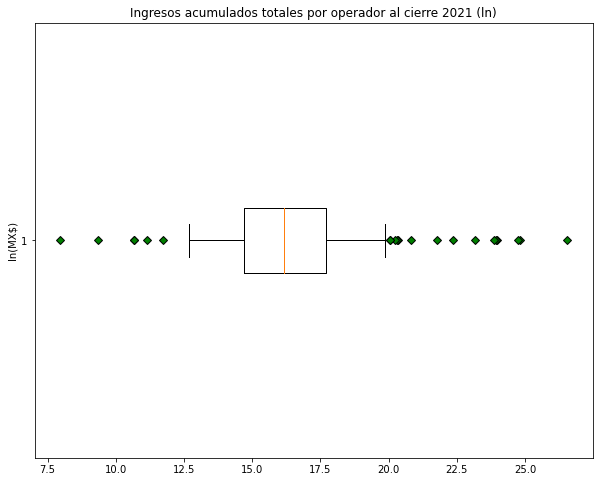

In [32]:
# Prueba de outliers (los grandes operadores)
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Ingresos acumulados totales por operador al cierre 2021 (ln)')
ax1.set_ylabel('ln(MX$)')
ax1.boxplot(ln_ingresos, flierprops=green_diamond, whis=0.75, vert=False)
plt.savefig('criterio_2021.png')
plt.show()

In [33]:
ln_ingresos

9     27
56    25
12    25
84    24
139   24
      ..
40    11
13    11
31    11
103    9
64     8
Name: INGRESOS_TOTAL_E, Length: 153, dtype: float64

In [34]:
ln_ingresos2 = pd.DataFrame(ln_ingresos)
ln_ingresos3 = ln_ingresos2['INGRESOS_TOTAL_E'].values.astype("float")
ln_ingresos3


array([26.54725844, 24.8059108 , 24.74492825, 23.97771236, 23.93699178,
       23.88083078, 23.16533712, 22.36395156, 21.76516941, 20.83139546,
       20.36302965, 20.31969459, 20.25101676, 20.05547391, 20.03705847,
       19.86188368, 19.85197294, 19.61294559, 19.44996932, 19.11320254,
       19.08879684, 18.95721111, 18.94029603, 18.93160975, 18.839676  ,
       18.81074584, 18.80296931, 18.61681864, 18.55456558, 18.53793852,
       18.40104514, 18.26841012, 18.24271372, 18.23952603, 18.23136339,
       17.87444519, 17.85650317, 17.81938348, 17.69898941, 17.58694855,
       17.5840466 , 17.53620457, 17.53359844, 17.49869154, 17.32545666,
       17.24938221, 17.23915779, 17.17111995, 17.12835637, 17.10103933,
       17.06328059, 16.94890035, 16.94587848, 16.92525951, 16.9235347 ,
       16.87157028, 16.85900466, 16.83961608, 16.81415941, 16.79283513,
       16.77851278, 16.62641399, 16.62638509, 16.49178006, 16.47749274,
       16.45152899, 16.40532671, 16.39876071, 16.39437544, 16.37

In [35]:
ln_ingresos2.index

Int64Index([  9,  56,  12,  84, 139,  54,  14,  87,   8, 120,
            ...
             92,  53, 144,  16,  29,  40,  13,  31, 103,  64],
           dtype='int64', length=153)

# Buscando el número de centroides (valores medios) óptimos a partir de la metodología Elbow y minimizar las distorciones.

In [36]:
ln_ingresos3.shape

(153,)

In [37]:
# Cuantificando las distorsiones.

from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ln_ingresos3.reshape(-1, 1))
    distortions.append(kmeanModel.inertia_)

D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


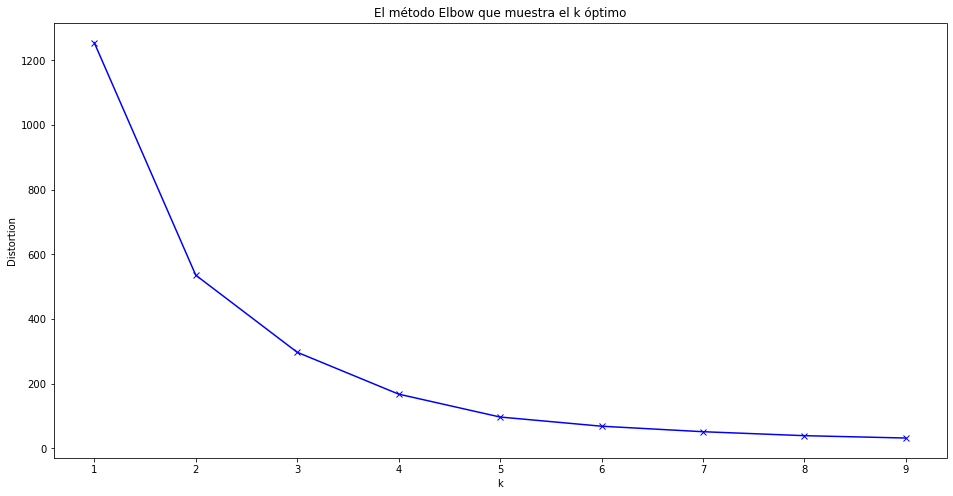

In [38]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('El método Elbow que muestra el k óptimo')
plt.show()

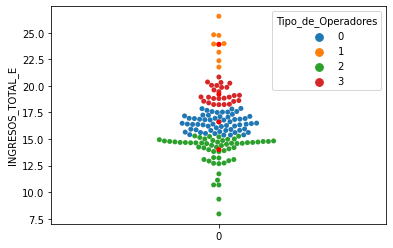

In [39]:
# Busquemos los clusters estadísticamente significativos
#use the kmeans function from scipy
from numpy import random
random.seed((1000,2000))
centroids, avg_distance = kmeans(ln_ingresos3, 4, iter=1000)
#extract the groups from the data
groups, cdit = vq(ln_ingresos3, centroids)
#plot the results
#assign groups back to the dataframe
ln_ingresos2["Tipo_de_Operadores"] = groups
#plot the scatter plot
# Usual boxplot

ax = sns.swarmplot(data=ln_ingresos2, x=np.ones(len(ln_ingresos2)), 
              y='INGRESOS_TOTAL_E', 
              hue=ln_ingresos2['Tipo_de_Operadores'])

ax = sns.swarmplot(data=centroids, color="red")
#ax = sns.boxplot(data=ln_ingresos2["INGRESOS_TOTAL_E"])

# remove legend if necessary
# plt.legend().remove()
plt.savefig('clusters_ingresos.png')
plt.show()

In [40]:
grande = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==1].reset_index()
grande

mediano =  ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==3].reset_index()
mediano

pequeño1 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==0].reset_index()
pequeño1

pequeño2 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==2].reset_index()
pequeño2


,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
0,132,15,2
1,49,15,2
2,128,15,2
3,114,15,2
4,98,15,2
5,70,15,2
6,57,15,2
7,154,15,2
8,113,15,2
9,119,15,2


In [41]:
# Se reemplazan las variables categóricas por la etiqueta correspondiente
ln_ingresos2["Tipo_de_Operadores"].replace({3: "Mediano", 1: "Grande", 2:"Pequeño2", 0:"Pequeño1"}, inplace=True)
ln_ingresos2 = ln_ingresos2.reset_index()
ln_ingresos2

,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
0,9,27,Grande
1,56,25,Grande
2,12,25,Grande
3,84,24,Grande
4,139,24,Grande
...,...,...,...
148,40,11,Pequeño2
149,13,11,Pequeño2
150,31,11,Pequeño2
151,103,9,Pequeño2


In [42]:
ingresos_por_grupo = ingresos_agrupados.reset_index()
cluster_total = ingresos_por_grupo.merge(ln_ingresos2, how='left', on='index')
cluster_total.to_csv("Clusters_totales_4clust.csv", encoding="Latin1")

In [43]:
grande = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Grande"]
grande

mediano =  ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Mediano"]
mediano

pequeño_1 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño1"]
pequeño_1

pequeño_2 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño2"]
pequeño_2


,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
96,132,15,Pequeño2
97,49,15,Pequeño2
98,128,15,Pequeño2
99,114,15,Pequeño2
100,98,15,Pequeño2
101,70,15,Pequeño2
102,57,15,Pequeño2
103,154,15,Pequeño2
104,113,15,Pequeño2
105,119,15,Pequeño2


In [44]:
ln_ingresos2

,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
0,9,27,Grande
1,56,25,Grande
2,12,25,Grande
3,84,24,Grande
4,139,24,Grande
...,...,...,...
148,40,11,Pequeño2
149,13,11,Pequeño2
150,31,11,Pequeño2
151,103,9,Pequeño2


D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


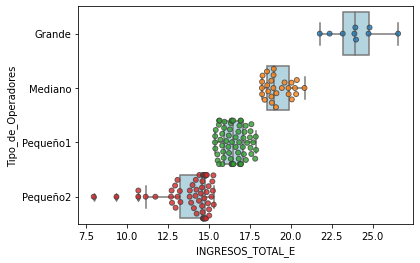

In [45]:
ax = sns.swarmplot(data=ln_ingresos2, x="INGRESOS_TOTAL_E", y="Tipo_de_Operadores", alpha=0.8, linewidth=.9)
ax = sns.boxplot(data=ln_ingresos2, x='INGRESOS_TOTAL_E', y="Tipo_de_Operadores",orient="h", color="lightblue")
plt.savefig("clusters_distribución.jpg")
#plt.show()

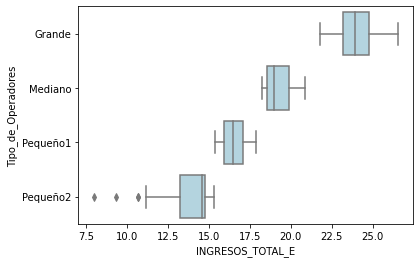

In [46]:
ax = sns.boxplot(data=ln_ingresos2, x='INGRESOS_TOTAL_E', y="Tipo_de_Operadores",orient="h", color="lightblue")

In [47]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',

In [48]:
print(ax.findobj())

[<matplotlib.lines.Line2D object at 0x00000210560C7040>, <matplotlib.lines.Line2D object at 0x00000210560C73A0>, <matplotlib.lines.Line2D object at 0x00000210560C7730>, <matplotlib.lines.Line2D object at 0x00000210560C7A90>, <matplotlib.lines.Line2D object at 0x00000210560C7DF0>, <matplotlib.lines.Line2D object at 0x00000210560D5190>, <matplotlib.lines.Line2D object at 0x00000210560D5820>, <matplotlib.lines.Line2D object at 0x00000210560D5B80>, <matplotlib.lines.Line2D object at 0x00000210560D5EE0>, <matplotlib.lines.Line2D object at 0x00000210560E0280>, <matplotlib.lines.Line2D object at 0x00000210560E05E0>, <matplotlib.lines.Line2D object at 0x00000210560E0940>, <matplotlib.lines.Line2D object at 0x00000210560E0EE0>, <matplotlib.lines.Line2D object at 0x00000210560ED280>, <matplotlib.lines.Line2D object at 0x00000210560ED5E0>, <matplotlib.lines.Line2D object at 0x00000210560ED940>, <matplotlib.lines.Line2D object at 0x00000210560EDCA0>, <matplotlib.lines.Line2D object at 0x0000021056

In [49]:
np.exp(17.7200000000003)

49624737.138494045

In [50]:
avg_distance

0.7772274401397564

# ¿Quiénes son los operadores en cada cluster?

In [51]:
# Primero preparemos la lista de operadores
ingresos = ingresos[['CONCESIONARIO', 'EMPRESA', 'GRUPO', 'INGRESOS_TOTAL_E']]
ingresos['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos['INGRESOS_TOTAL_E'])
ingresos = ingresos.groupby(['CONCESIONARIO', 'EMPRESA', 'GRUPO']).sum().reset_index().sort_values(by=['INGRESOS_TOTAL_E'], ascending=False)
ingresos

<ipython-input-51-daabab6c15c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos['INGRESOS_TOTAL_E'])


,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
122,"RADIOMOVIL DIPSA, S.A. DE C.V.",TELCEL,AMÉRICA MÓVIL,218288998808
165,"TELEFONOS DE MEXICO, S.A.B. DE C.V.",TELMEX,AMÉRICA MÓVIL,120031140723
12,"AT&T COMUNICACIONES DIGITALES, S. DE R.L. DE C.V.",AT&T,AT&T,55793781168
119,"PEGASO PCS, S.A. DE C.V.",MOVISTAR,TELEFÓNICA,24871583943
47,CORPORACION DE RADIO Y TELEVISION DEL NORTE DE...,SKY,GRUPO TELEVISA,24112031768
...,...,...,...,...
144,"SUPERCABLE TIXKOKOB, S.A. DE C.V.",SUPERCABLE TIXKOKOB,SUPERCABLE TIXKOKOB,0
181,"TV ZAC, S.A. DE C.V.",TV ZAC,TV ZAC,0
70,"GRUPO PROFREZAC, S.A. DE C.V.",STARKA,STARKA,0
129,SERGIO PEDROZA AGUILERA,SERGIO PEDROZA AGUILERA,SERGIO PEDROZA AGUILERA,0


## Grandes

In [52]:
lista_grandes = grande["index"]
lista_original = ingresos_agrupados_transformables.reset_index()
grandes_operadores = lista_original[lista_original['index'].isin(lista_grandes)]
grandes_operadores.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
0,9,AMÉRICA MÓVIL,338320139531
1,56,GRUPO TELEVISA,59302114566
2,12,AT&T,55793781168
3,84,MEGACABLE-MCM,25905272620
4,139,TELEFÓNICA,24871583943
5,54,GRUPO SALINAS,23513270106
6,14,AXTEL,11496829253
7,87,MVS,5158705766
8,8,ALTAN,2834607753


In [53]:
# Las empresas que no serían elegibles por estar en el cluster de los grandes operadores:

lista_cluster_grande = grandes_operadores['GRUPO'].unique()
lista_cluster_grande

array(['AMÉRICA MÓVIL', 'GRUPO TELEVISA', 'AT&T', 'MEGACABLE-MCM',
       'TELEFÓNICA', 'GRUPO SALINAS', 'AXTEL', 'MVS', 'ALTAN'],
      dtype=object)

In [54]:
# Se trata de 27 operadores que son por sí solos grandes operadores o pertenecen a un GIE grande. 

lista_empresas_cluster_grande = ingresos[ingresos['GRUPO'].isin(lista_cluster_grande)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_grande.to_csv("Empresas_grandes.csv", encoding="Latin1")

lista_empresas_cluster_grande

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
122,"RADIOMOVIL DIPSA, S.A. DE C.V.",TELCEL,AMÉRICA MÓVIL,218288998808
165,"TELEFONOS DE MEXICO, S.A.B. DE C.V.",TELMEX,AMÉRICA MÓVIL,120031140723
12,"AT&T COMUNICACIONES DIGITALES, S. DE R.L. DE C.V.",AT&T,AT&T,55793781168
119,"PEGASO PCS, S.A. DE C.V.",MOVISTAR,TELEFÓNICA,24871583943
47,CORPORACION DE RADIO Y TELEVISION DEL NORTE DE...,SKY,GRUPO TELEVISA,24112031768
107,"MEGA CABLE, S.A. DE C.V.",MEGACABLE,MEGACABLE-MCM,23567319612
178,"TOTAL PLAY TELECOMUNICACIONES, S.A. DE C.V.",TOTALPLAY,GRUPO SALINAS,22784126736
15,"AXTEL, S.A.B. DE C.V.",AXTEL,AXTEL,11496829253
25,"CABLEMAS TELECOMUNICACIONES, S.A. DE C.V.",IZZI,GRUPO TELEVISA,9765026568
30,"CABLEVISION, S.A. DE C.V.",CABLEVISION,GRUPO TELEVISA,7858397482


## Medianos

In [55]:
lista_medianos = mediano["index"]
lista_original = ingresos_agrupados_transformables.reset_index()
operadores_medianos = lista_original[lista_original['index'].isin(lista_medianos)]
operadores_medianos.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
9,120,STARGROUP,1114192165
10,80,MARCATEL,697511564
11,89,NETWEY,667930436
12,147,TRANSTELCO,623598170
13,28,CENTURYLINK,512839717
14,63,HNS DE MEXICO,503481972
15,143,TELIA CARRIER COMMUNICATIONS MEXICO,422577610
16,62,HISPASAT,418410240
17,152,UC TELECOM,329453439
18,17,BT LATAM MEXICO,279907380


In [56]:
# Las empresas que no serían elegibles por estar en el cluster de los medianos operadores:

lista_cluster_mediano = operadores_medianos['GRUPO'].unique()
lista_cluster_mediano

array(['STARGROUP', 'MARCATEL', 'NETWEY', 'TRANSTELCO', 'CENTURYLINK',
       'HNS DE MEXICO', 'TELIA CARRIER COMMUNICATIONS MEXICO', 'HISPASAT',
       'UC TELECOM', 'BT LATAM MEXICO', 'ELARA COMUNICACIONES',
       'VERIZON SERVICIOS EMPRESARIALES MEXICO', 'GLOBALSAT', 'NEWWW',
       'WIMOTELECOM', 'IENTC', 'SERVITRON', 'VIRGIN MOBILE',
       'GRUPO TELECABLE', 'TELECABLE DEL MINERAL', 'FREEDOM',
       'DIRI MOVIL', 'FLASH MOBILE', 'IST', 'HIPERCABLE DE MONCLOVA',
       'QUATTROCOM'], dtype=object)

In [57]:
# Se trata de 34 operadores que son por sí solos son medianos operadores o pertenecen a un GIE mediano. 

lista_empresas_cluster_medianos = ingresos[ingresos['GRUPO'].isin(lista_cluster_mediano)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_medianos.to_csv("Empresas_medianas.csv", encoding="Latin1")

lista_empresas_cluster_medianos

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
71,"GRUPO W COM, S.A. DE C.V.",STAR GO/STAR TV,STARGROUP,858427009
102,"MARCATEL COM, S.A. DE C.V.",MARCATEL,MARCATEL,697511564
86,"ISLIM TELCO, S.A.P.I. DE C.V.",NETWEY,NETWEY,667930436
105,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,623598170
52,"CTL MEXICO LANDING, S. DE R.L.",CENTURYLINK,CENTURYLINK,512839717
79,"HNS DE MEXICO, S.A. DE C.V.",HNS DE MEXICO,HNS DE MEXICO,503481972
175,"TELIA CARRIER COMMUNICATIONS MEXICO, S.A. DE C.V.",TELIA CARRIER COMMUNICATIONS MEXICO,TELIA CARRIER COMMUNICATIONS MEXICO,422577610
182,"UC TELECOMUNICACIONES, S.A.P.I. DE C.V.",UC TELECOM,UC TELECOM,329453439
18,"BT LATAM MEXICO, S.A. DE C.V.",BT LATAM MEXICO,BT LATAM MEXICO,279907380
170,"TELEVERA RED, S.A.P.I. DE C.V.",TELEVERA RED,STARGROUP,255765156


## Cluster_1 de operadores pequeños

In [67]:
lista_pequeños1 = pequeño_1["index"]
operadores_pequeños_1 = lista_original[lista_original['index'].isin(lista_pequeños1)]
operadores_pequeños_1 = operadores_pequeños_1.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)
operadores_pequeños_1

,index,GRUPO,INGRESOS_TOTAL_E
35,135,TELECABLE MERIDA,57912580
36,100,RAVS CABLE,56882777
37,155,VASANTA,54810014
38,32,COMUNICACION B15,48592969
39,110,SIERRA MADRE TELECOM,43442490
...,...,...,...
91,10,ANKLA,5437985
92,60,HERMOVISION,4917794
93,45,EYCO DE LOS ALTOS,4796983
94,88,NET LINK,4756865


In [59]:
# Las empresas que no serían elegibles por estar en el cluster de los pequeños1:
lista_cluster_pequeños_1 = operadores_pequeños_1['GRUPO'].unique()
lista_cluster_pequeños_1

array(['TELECABLE MERIDA', 'RAVS CABLE', 'VASANTA', 'COMUNICACION B15',
       'SIERRA MADRE TELECOM', 'YOBI TELECOM', 'TELECABLE', 'RBACATV',
       'LINK TE CONECTAMOS', 'WEEX', 'BBG COMUNICACION',
       'SARA QUIROZ CHAPA', 'SCT', 'ALESTRA', 'COSMORED', 'CCA',
       'CABLEVISION DE APATZINGAN', 'MARCO ANTONIO ROSALES HERRERA',
       'NEXT TELEKOM', 'SIHI MEXICO', 'TELECABLE DE RIOVERDE',
       'TELECABLE DE XALTIANGUIS', 'TELECOM NACIONAL', 'LAREDONET',
       'TELECABLE DE TAMAYO', 'DIVERSICABLE', 'SPACENET',
       'CABLE DEL VALLE DE TOLUCA', 'USA TELECOM', 'SUPERCOM',
       'TELEVISION DE PEDRO ESCOBEDO', 'AIRECABLE',
       'OPERADORA TELEFONICA PENINSULAR', 'MAXICABLE', 'COMCAB',
       'GURUCOMM', 'CABLEPLAY', 'SIMPATI', 'MUCHOS MEGAS', 'LOGITEL',
       'CABLE DIVERSION', 'OTROS', 'TELECOMUNICACIONES DE CERRITOS',
       'TV OJO CALIENTE', 'FRANCISCO GUERRA GARCIA',
       'TELECABLE DE COAHUAYANA', 'ALEJANDRO MELGAREJO CORTES', 'TELEWEB',
       'PROTOKOL TELECOMUNICAC

In [60]:
# Se trata de 64 operadores que por sí solos son pequeños operadores o pertenecen a un GIE pequeño. 

lista_empresas_cluster_pequeños_1 = ingresos[ingresos['GRUPO'].isin(lista_cluster_pequeños_1)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_pequeños_1.to_csv("Empresas_pequeñas_c1.csv", encoding="Latin1")

lista_empresas_cluster_pequeños_1

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
152,"TELECABLE DE MERIDA, S.A. DE C.V.",TELECABLE MERIDA,TELECABLE MERIDA,57912580
126,ROBERTO ANTONIO MALDONADO GUTIERREZ,RAVS CABLE,RAVS CABLE,56882777
185,"VASANTA COMUNICACIONES, S.A.P.I. DE C.V.",VASANTA,VASANTA,54810014
40,"COMUNICACION B15, S.A. DE C.V.",COMUNICACION B15,COMUNICACION B15,48592969
132,"SIERRA MADRE INTERNET, S.A. DE C.V.",SIERRA MADRE,SIERRA MADRE TELECOM,43442490
...,...,...,...,...
10,"ANKLA, S.A. DE C.V.",ANKLA,ANKLA,5437985
76,"HERMOVISION, S. DE R.L. DE C.V.",HERMOVISION,HERMOVISION,4917794
61,"EYCO DE LOS ALTOS, S. DE R.L. DE C.V.",EYCO DE LOS ALTOS,EYCO DE LOS ALTOS,4796983
111,NATALIA CHAREEVA,NET LINK,NET LINK,4756865


# Cluster 2 de operadores pequeños

In [61]:
lista_pequeños2 = pequeño_2["index"]
operadores_pequeños_2 = lista_original[lista_original['index'].isin(lista_pequeños2)]
operadores_pequeños_2.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
96,132,TELECABLE DE VILLANUEVA,4355978
97,49,GABRIEL BUTRON CHIAPA,4266116
98,128,TELECABLE DE EL NARANJO,4135348
99,114,SISCAB DE MEXICO,4003498
100,98,RADIO FRECUENCIAS CONCESIONADAS,3778876
101,70,JACE TELECOM,3300058
102,57,GUILLERMO MEDELLIN MILAN,3273959
103,154,VADSA,3185056
104,113,SINOTECA,3063188
105,119,STAR NET,2856870


In [62]:
# Las empresas que no serían elegibles por estar en el cluster de los pequeños1:
lista_cluster_pequeños_2 = operadores_pequeños_2['GRUPO'].unique()
lista_cluster_pequeños_2

array(['TELECABLE DE VILLANUEVA', 'GABRIEL BUTRON CHIAPA',
       'TELECABLE DE EL NARANJO', 'SISCAB DE MEXICO',
       'RADIO FRECUENCIAS CONCESIONADAS', 'JACE TELECOM',
       'GUILLERMO MEDELLIN MILAN', 'VADSA', 'SINOTECA', 'STAR NET',
       'MIIO', 'AGUSTIN PEREZ VIEYRA', 'SECSA', 'INTEGRA COMUNICACIONES',
       'GOBO', 'TELEVISION POR CABLE DE MUZQUIZ',
       'ARELY ISABEL GONGORA PECH', 'TELECABLE DE AGUILILLA',
       'SPACEX-STARLINK', 'TELECAB', 'ROBERTO LOPEZ BRAVO',
       'CONSORCIO JAGO COMUNICACIONES', 'MARKETING 358', 'CONCABLETV',
       'JESUS MIGUEL FERNANDEZ GUERRERO', 'ESPID', 'MANUEL LOPEZ AVILA',
       'INTERCABLE DEL MAYAB', 'RED DOG', 'DANIEL GARCIA GODINEZ',
       'TELECOMUNICACIONES DIVERSIFICADAS',
       'ENTRETENIMIENTO Y TELECOMUNICACIONES', 'GUILLERMO ZARATE GARCIA',
       'JOSE JULIAN SACRAMENTO GARZA', 'CABLEVISION DE LA HUACANA',
       'RAFAEL SANCHEZ NAZARIEGA', 'CRO.NET', 'SISTEMA DE CABLE HKAN',
       'CABLE SALTO DEL AGUA', 'TV-K', 'ES TV C

In [63]:
# Se trata de 43 operadores que por sí solos son pequeños operadores o pertenecen a un GIE pequeño. 

lista_empresas_cluster_pequeños_2 = ingresos[ingresos['GRUPO'].isin(lista_cluster_pequeños_2)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_pequeños_2.to_csv("Empresas_pequeñas_c2.csv", encoding="Latin1")

lista_empresas_cluster_pequeños_2

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
157,"TELECABLE DE VILLANUEVA, S.A. DE C.V.",TELECABLE DE VILLANUEVA,TELECABLE DE VILLANUEVA,4355978
64,GABRIEL BUTRON CHIAPA,GABRIEL BUTRON CHIAPA,GABRIEL BUTRON CHIAPA,4266116
151,"TELECABLE DE EL NARANJO, S.A. DE C.V.",TELECABLE DE EL NARANJO,TELECABLE DE EL NARANJO,4135348
135,"SISCAB DE MEXICO, S.A. DE C.V.",SISCAB DE MEXICO,SISCAB DE MEXICO,4003498
121,"RADIO FRECUENCIAS CONCESIONADAS, S.A. DE C.V.",RADIO FRECUENCIAS CONCESIONADAS,RADIO FRECUENCIAS CONCESIONADAS,3778876
87,"JACE TELECOM, S.A. DE C.V.",JACE TELECOM,JACE TELECOM,3300058
73,GUILLERMO MEDELLIN MILAN,GUILLERMO MEDELLIN MILAN,GUILLERMO MEDELLIN MILAN,3273959
184,"VALOR AGREGADO DIGITAL, S.A. DE C.V.",VADSA,VADSA,3185056
133,"SIERRA NORTE TELEVISION POR CABLE, S.A. DE C.V.",SINOTECA,SINOTECA,3063188
141,"STAR NET, S.A. DE C.V.",STAR NET,STAR NET,2856870


In [64]:
total_ingresos = ingresos_agrupados_transformables["INGRESOS_TOTAL_E"].sum()
ingreos_grandes= lista_empresas_cluster_grande["INGRESOS_TOTAL_E"].sum()
ingresos_medianas = lista_empresas_cluster_medianos["INGRESOS_TOTAL_E"].sum()
ingresos_pequeñas1 = lista_empresas_cluster_pequeños_1["INGRESOS_TOTAL_E"].sum()
ingresos_pequeñas2 = lista_empresas_cluster_pequeños_2["INGRESOS_TOTAL_E"].sum()

print(f"El 14.8% del total de empresas(cluster empresas grandes) generan el {round(ingreos_grandes/total_ingresos*100,2)}% de los ingresos")
print(f"El 18.7% del total de empresas (cluster empresas medianas) generan el {round(ingresos_medianas/total_ingresos*100,2)}% de los ingresos")
print(f"El 66.48% del total de empresas (cluster empresas pequeñas 1 y 2) generan el {round((ingresos_pequeñas1+ingresos_pequeñas2)/total_ingresos*100,2)}% de los ingresos")



El 14.8% del total de empresas(cluster empresas grandes) generan el 98.38% de los ingresos
El 18.7% del total de empresas (cluster empresas medianas) generan el 1.38% de los ingresos
El 66.48% del total de empresas (cluster empresas pequeñas 1 y 2) generan el 0.23% de los ingresos


In [65]:
# Análisis con quartiles y rango intercuantil para efectos de identificar los outliers

quartiles = lista_empresas_cluster_pequeños_1["INGRESOS_TOTAL_E"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"El cuartil más bajo de los ingresos es: {lowerq}")
print(f"El cuartil más alto de los ingresos es: {upperq}")
print(f"El rango intercuantil de los ingresos es: {iqr}")
print(f"El ingreso medio es: {quartiles[0.5]} ")


lower_bound = lowerq - (2.4*iqr)
upper_bound = upperq + (2.4*iqr) # se circunscribe al 99% de los datos con un valor de la media +- 3.9sigma.
print(f"Umbral final donde los valores por encima de {upper_bound} no son elegibles.")



El cuartil más bajo de los ingresos es: 7935550.5375
El cuartil más alto de los ingresos es: 22899709.945
El rango intercuantil de los ingresos es: 14964159.4075
El ingreso medio es: 13283710.895 
Umbral final donde los valores por encima de 58813692.523 no son elegibles.


# Conclusiones

### <font color="green"> El umbral para ser elegible como pequeño operador implica ingresos nominales acumulados al cierre de 2021 menores o iguales a <font color="red"> MX$58,813,692 </font>, para efectos de garantizar que la empresa en cuestión se encuentra dentro de alguno de los dos clusters identificados por su ingreso relativamente pequeño.

- Con base en los datos del BIT se registran 85 empresas con ingresos menores o iguales al umbral definido. Esto equivale al 62.5% de todas las empresas.

- El 17.6% del total de empresas (cluster empresas grandes) generan el 98.49% de los ingresos.

- El 19.9% del total de empresas (cluster empresas medianas) generan el 1.32% de los ingresos.

- El 62.5% del total de empresas (cluster empresas pequeñas 1 y 2) generan el 0.19% de los ingresos.

- La definición de este umbral con base en una técnica confiable y robusta permite contar con un criterio cuantitativo y objetivo sobre lo que se debe considerar como un operador elegible para participar en el Comité de Pequeños Operadores.

-  Se trata de un criterio claro, transparente y replicable, que brinda certeza jurídica y confianza al sector.

</font>

